## 2D attempt at solving the bidomain equations:

In [1]:
from fenics import *
import numpy as np
from configs import *
from mesh_generator import mesh_maker

### Generating a mesh:

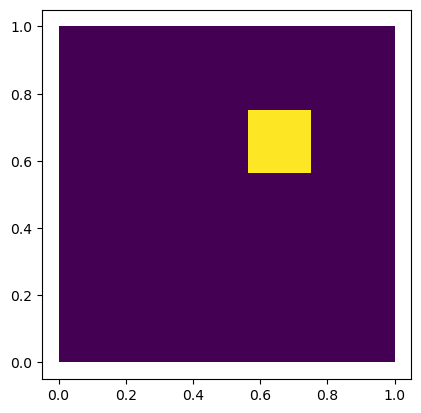

In [2]:
mesh, cellfunction, facetfunction = mesh_maker()
torsomesh = SubMesh(mesh, cellfunction, 0)
heartmesh = SubMesh(mesh, cellfunction, 1)
plot(cellfunction)

### Bidomain model:

In [3]:
# fibers, parametrized with mesh
def fib(mesh):
    coords = SpatialCoordinate(mesh)
    norm = sqrt(dot(coords, coords))
    vector_field = as_vector([coords[1] / norm, -coords[0] / norm])
    return vector_field

# conductivities
sigma_il = Constant(SIGMA_IL, name="sigma_il")
sigma_it = Constant(SIGMA_IT, name="sigma_it")
sigma_el = Constant(SIGMA_EL, name="sigma_el")
sigma_et = Constant(SIGMA_ET, name="sigma_et")
sigma_tlt = Constant(SIGMA_TLT, name="sigma_t")

d = mesh.topology().dim()
sigma_i = lambda msh: sigma_it * Identity(d) + (sigma_il - sigma_it) * outer(fib(msh), fib(msh))
sigma_e = lambda msh: sigma_et * Identity(d) + (sigma_el - sigma_et) * outer(fib(msh), fib(msh))
sigma_t = lambda _: sigma_tlt * Identity(d)


In [ ]:
# setting up a model
V_torso = FunctionSpace(heartmesh, 'Lagrange', 1)
V_heart = FunctionSpace(torsomesh, 'Lagrange', 1)
V = FunctionSpace(mesh, 'Lagrange', 1)

u, v= TrialFunction(V), TestFunction(V)
v = TestFunction(V)

In [5]:
# Define input data
a0 = Constant(1.0)
a1 = Constant(0.01)
g_L = Expression("- 10*exp(- pow(x[1] - 0.5, 2))", degree=1)
g_R = Constant("1.0")
f = Constant(1.0)

In [6]:
# Define function space and basis functions
V = FunctionSpace(mesh, "CG", 2)


In [7]:
# Define Dirichlet boundary conditions at top and bottom boundaries
bcs = [DirichletBC(V, 5.0, facetfunction, 2), DirichletBC(V, 0.0, facetfunction, 4)]

In [8]:
# Define new measures associated with the interior domains and
# exterior boundaries
dx = Measure("dx")(subdomain_data=cellfunction)
ds = Measure("ds")(subdomain_data=facetfunction)

In [9]:
# Define variational form
F = (
    inner(a0 * grad(u), grad(v)) * dx(0)
    + inner(a1 * grad(u), grad(v)) * dx(1)
    - g_L * v * ds(1)
    - g_R * v * ds(3)
    - f * v * dx(0)
    - f * v * dx(1)
)

In [10]:
# Separate left and right hand sides of equation
a, L = lhs(F), rhs(F)

In [11]:
# Solve problem
u = Function(V)
solve(a == L, u, bcs)

Solving linear variational problem.
  *** Warning: Found no facets matching domain for boundary condition.
  *** Warning: Found no facets matching domain for boundary condition.


In [12]:
# Evaluate integral of normal gradient over top boundary
n = FacetNormal(mesh)
m1 = dot(grad(u), n) * ds(2)
v1 = assemble(m1)
print("\int grad(u) * n ds(2) = ", v1)

\int grad(u) * n ds(2) =  0.0


In [13]:
# Evaluate integral of u over the obstacle
m2 = u * dx(1)
v2 = assemble(m2)
print("\int u dx(1) = ", v2)

\int u dx(1) =  43565862716.49426


Object cannot be plotted directly, projecting to piecewise linears.


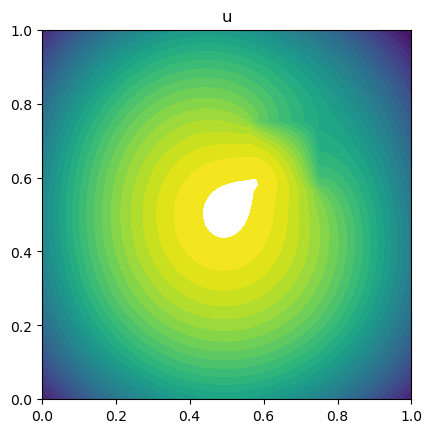

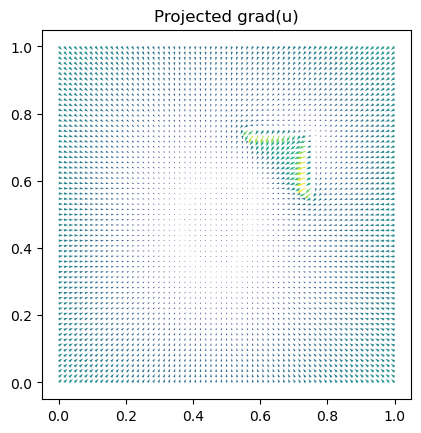

In [14]:
# Plot solution and gradient
plot(u, title="u")
plot(grad(u), title="Projected grad(u)")